# Many-objective Optimal Scheduling of Smart Home Energy Systems

This tutorial shows the use of Artificial Intelligence Algorithms for optimal scheduling of a typical smart home energy system. The system models,such as PV, thermostatically controlled loads, and shifting loads were developed based on real-world test data. Then, this example shows how to use Artificial Intelligence Algorithms to conduct a many-objective day-ahead optimal scheduling of smart home energy systems.Experiment was conducted to verify the proposed methods. 

# Import Packages

The first step in performing the day-ahead optimal scheduling is installing external Python packages. There are many open-source packages for data science and machine learning that are commonly used and assist with data manipulation, plotting, and modeling. 
Besides, some packages were defined by ourselves. The following command loads the popular Pandas and Matplotlib packages.

Platypus - Multiobjective Optimization in Python

pip install Platypus-Opt

In [16]:
import numpy as np
import pandas as pd
from platypus import NSGAIII, Problem, Real, operators
# from functions import function # Customizable packages which are used to calculate objective functions of optimal models
# from PVBF import Systemmodel # Customizable packages which are used to develop system models of the home energy system
# from Paths import Path
import time
import datetime
import math
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import MultipleLocator
import seaborn as sns

# Define functions (e.g., decision making)
Customizable packages which are used to perform the decision process

In [ ]:
# normalization
def Standard(datas, D):
    data_final = pd.DataFrame([], columns=['a'])
    k = np.power(np.sum(pow(datas, 2), axis=0), 0.5)
    for i in range(len(k)):
        mnq = datas.iloc[:, i]/k[i+D]
        data_final = pd.concat([data_final, mnq], axis=1, sort=False)
    data_final = data_final.drop(['a'], axis=1)
    return data_final

# Relative proximities calculation and sorting
def Score(sta_data):
    z_max = np.amax(sta_data,axis=0)
    z_min = np.amin(sta_data,axis=0)
    # Euclidian distance computation
    tmpmaxdist = np.power(np.sum(np.power((z_max - sta_data) , 2) , axis = 1) , 0.5)
    tmpmindist = np.power(np.sum(np.power((z_min - sta_data) , 2) , axis = 1) , 0.5)
    # Relative proximities calculation and sorting
    score = tmpmindist / (tmpmindist + tmpmaxdist)
    score = score / np.sum(score)
    return score

def Topsis(population, D, M):
    data = population.iloc[:, D:D+M]
    # normalization
    data_sta = Standard(data, D)
    # Weighted normalized decision matrix creation
    weights = [1/M] * M
    w = pd.DataFrame({'weight': weights})
    data_e = data_sta.values
    data_f = data_e/np.repeat(w.values.reshape(1, M), data_e.shape[0], axis=0)
    # Relative proximities calculation and sorting
    score = Score(data_f)
    score1 = pd.DataFrame(score, columns=['Score'])
    result = pd.concat([population, score1], axis=1, sort=False)
    res = result.loc[result['Score'] == max(score)]
    return res

# Define system model
Electric water heater and air conditioner 

In [3]:
# Storage path of input data
data_path = 'data/chapter3/chapter3.2/Simulation'

# input outdoor environmental data
dataset = pd.read_csv(data_path + '/Environment.csv')
q1, q2 = dataset.shape
T_out = dataset['outdoor temperature'].values

# Input the ambient temperature around the electric water heater
dataset_ewh = pd.read_csv(data_path + '/Environment-ewh.csv')
q1_ewh, q2_ewh = dataset_ewh.shape
T_out_ewh = dataset_ewh['Environment temperature'].values  #

# Input hot water loads
dataset_water_usage = pd.read_csv(data_path + '/Hot water load.csv')
V_usage = dataset_water_usage['Hot water usage'].values  # unit，L

# Data input of the electric water heater
Tw_in = np.zeros(q1_ewh + 1)
P_in_ewh = np.zeros(q1_ewh)
T_set_ewh = np.zeros(q1_ewh)
Vv = np.zeros(q1_ewh)

# Data input of the air conditioner
Tin = np.zeros(q1 + 1)
P_in_AC = np.zeros(q1)
T_set_AC = np.zeros(q1)

Tin_noon = np.zeros(q1 + 1)
P_in_AC_noon = np.zeros(q1)
T_set_AC_noon = np.zeros(q1)

Tin_AC2 = np.zeros(q1 + 1)
P_in_AC2 = np.zeros(q1)
T_set_AC2 = np.zeros(q1)

class Systemmodel(object):

    def model_ewh(self, set_point_ewh, Aum, t_step):
        '''
        Electric water heater model
        '''
        # model parameters
        P_rated_ewh = 2600  # Rated heating power，W
        v_ewh = 5  # Thermostat dead-band，℃
        Tw_in[0] = 59  # Initial value of hot water temperature，℃
        k1 = 0.9997822368417145
        k2 = 0.00021776315828547776
        k3 = 0.00023363496878276119
        k4 = -0.0002920437109784515
        k5 = -5.8408742195690296e-05
        global U3

        for t in range(Aum, Aum + t_step, 1):
            T_set_ewh[t] = set_point_ewh  # Temperature setpoint
            Tmax = T_set_ewh[t]
            Tmin = T_set_ewh[t] - v_ewh
            if t == 0:
                new_U_ewh = 0
            else:
                if Tw_in[t] <= Tmin:
                    new_U_ewh = 1
                elif Tw_in[t] >= Tmax:
                    new_U_ewh = 0
                else:
                    new_U_ewh = U3

            P_in_ewh[t] = P_rated_ewh * new_U_ewh
            Qin_cooling = V_usage[t]
            Tw_in[t + 1] = k1 * Tw_in[t] + k2 * T_out_ewh[t] + k3*P_in_ewh[t] + k4 * Qin_cooling + k5
            U3 = new_U_ewh
            if new_U_ewh == 1 and Tw_in[t + 1] > Tmax:
                Tw_in[t + 1] = Tmax
        return P_in_ewh, Tw_in

    def model_ac1_mon(self, t_start, Tin_start, set_point_ac, Aum, t_step):
        '''
        Room air conditioner model
        '''
        # Parameters of thermodynamic model of air-conditioned rooms
        k1 = 0.989227
        k2 = 0.001074
        k3 = -0.000108
        k4 = 0.295523

        # AC electric model parameters
        P_AC_rated = 910  # Rated operation power
        v = 0.3  # Thermostat dead-band

        # Initial value
        t_ac_start = t_start # Turn-on moment of AC
        Tin[t_ac_start] = Tin_start  # Initial value of indoor air temperature

        # Model development
        for t in range(Aum, Aum + t_step, 1):
            # Adjust temperature set-point
            T_set_AC[t] = set_point_ac
            # AC electric model
            New_U1 = 1
            global U2
            if t == t_ac_start:
                New_U2 = 1
            else:
                if Tin[t] < T_set_AC[t] - v / 2:
                    New_U2 = 0
                elif Tin[t] > T_set_AC[t] + v / 2:
                    New_U2 = 1
                else:
                    New_U2 = U2
            P_in_AC[t] = New_U1 * (New_U2 * P_AC_rated + 19 * (1 - New_U2))
            P_AC_out = New_U1 * New_U2 * P_in_AC[t]
            U2 = New_U2
            U1 = New_U1
            # Thermodynamic model of air-conditioned rooms
            Tin[t + 1] = k1 * Tin[t] + k2*T_out[t] +k3*P_AC_out+k4
        return P_in_AC, Tin

    def model_behavior(self):
        '''
        Occupant behaviors of flexible household appliance usage
        '''
        # --------------------Operation time--------------------#
        t_start_point = 6  # Initial time slot,6:00
        t_ac_start = int((9 - t_start_point) * 60)  # Turn-on moment of AC
        t_ac_end = int(t_ac_start + 15*60) # Turn-off moment of AC
        t_wm_start = int((6 - t_start_point) * 60)  # The range of turn-on moment of the appliance can be adjusted,[t_wm_start,t_wm_end]
        t_wm_end = int((8 - t_start_point) * 60)
        t_dw_start = int((19 - t_start_point) * 60)  #The range of turn-on moment of the appliance can be adjusted,[t_dw_start,t_dw_end]
        t_dw_end = int((24 + 6 - t_start_point) * 60 - 106)
        # --------------------Preference of temperature setting--------------------#
        T_set_AC_min = 24
        T_set_AC_max = 29
        T_set_ewh_min = 50
        T_set_ewh_max = 75
        return t_ac_start, t_ac_end, t_wm_start, t_wm_end, t_dw_start, t_dw_end, \
               T_set_AC_min, T_set_AC_max, T_set_ewh_min, T_set_ewh_max

In [9]:
class function(object):
    def objective_function(self, decision_variable, Num_ewh, Num_ac, obj): #Num_cd, Num_dw,
        '''
        Calculate objective functions
        '''
        # --------------------Input data--------------------#
        dataset = pd.read_csv(data_path+'/Environment.csv') # input ambient temperature
        q1, q2 = dataset.shape

        # input PV generation data
        Number_pv = 20
        dataset_pv = pd.read_csv(data_path + '/PV generation.csv')
        Pout_PV = dataset_pv['power'].values
        Price_pv = 4  # unit capital cost of PV，CNY/W
        Price_sale_power = 0.42  # feed-in-tariff，CNY/kWh

        # input inflexible loads
        dataset_inflexible_load = pd.read_csv(data_path + '/Inflexible load.csv')
        P_infle_load = dataset_inflexible_load['inflexible load'].values

        # obtain occupant behaviors of flexible household appliance usage
        model = Systemmodel()
        t_ac_start, t_ac_end, t_wm_start, t_wm_end,t_dw_start, t_dw_end,\
        T_set_AC_min, T_set_AC_max, T_set_ewh_min, T_set_ewh_max = model.model_behavior()

        # -----------------------Calculation of thermostatically controlled loads operation-----------------------#
        t_step = 30  # Optimization time step, 30min
        variable_index = 0
        # EWH calculation
        for Aum in range(0, q1 - 1, t_step):
            set_point_ewh = int(decision_variable[variable_index])
            P_in_ewh, Tw_in = model.model_ewh(set_point_ewh, Aum, t_step)
            variable_index = variable_index + 1

        # AC calculation
        Tin_start = 28
        for Aum in range(t_ac_start, t_ac_end, t_step):
            set_point_ac = decision_variable[variable_index]
            if Aum == int((t_ac_end - t_ac_start) / t_step):
                step = int(t_ac_end - Aum * t_step)
            else:
                step = t_step
            P_in_AC, Tin = model.model_ac1_mon(t_ac_start, Tin_start, set_point_ac, Aum, step)
            variable_index = variable_index + 1

        # -----------------Calculation of shifting loads operation-------------------#
        # Washing and dryer calculation
        global t_shift_wm_ref
        dataset_wm = pd.read_csv(data_path + '/Washing and dryer.csv')
        q1_wm, q2_wm = dataset_wm.shape
        P_wm = dataset_wm['Power'].values
        P_in_wm = np.zeros(24 * 60)
        t_shift_wm_ref = int(decision_variable[int(Num_ewh + Num_ac)])
        P_in_wm[t_shift_wm_ref:t_shift_wm_ref + q1_wm] = P_wm

        # Dishwasher calculation
        dataset_dw = pd.read_csv(data_path + '/Dishwasher.csv')
        q1_dw, q2_dw = dataset_dw.shape
        P_dw = dataset_dw['Power'].values
        P_in_dw = np.zeros(24 * 60)
        t_shift_dw_ref = int(decision_variable[int(Num_ewh + Num_ac + 1)])
        P_in_dw[t_shift_dw_ref:t_shift_dw_ref + q1_dw] = P_dw

        # Total electrical loads
        P_load = P_infle_load + P_in_ewh + P_in_AC + P_in_wm + P_in_dw
        # net power
        P_grid = Pout_PV - P_load

        # --------------------------------------Performance evaluation----------------------------------#
        # ---------------------------------------PV generation consumption-------------------------------------#
        # Self-consumption rate (SCR)
        Ep_d = 0
        for i in range(q1):
            if P_grid[i] > 0:
                Ep_d = Ep_d + P_grid[i]  # Power feed-in utility grids，W
        SCR = -(sum(Pout_PV) - Ep_d) / sum(Pout_PV)
        # Self-sufficiency rate (SSR)
        SSR = -(sum(Pout_PV) - Ep_d) / sum(P_load)

        # -----------------------------------Daily operation costs-----------------------------------#
        # electricity bills
        Puch_power_vally = 0
        Puch_power_flat = 0
        Puch_power_peak = 0
        Power_vally = 0.229  # TOU price，CNY/kWh
        Power_flat = 0.573
        Power_peak = 0.9168
        for i in range(q1):
            if P_grid[i] < 0:
                if i < (7 - 6) * 60 or (23 - 6) * 60 <= i < (30 - 6) * 60:
                    Puch_power_vally = Puch_power_vally + P_grid[i]
                elif (7 - 6) * 60 <= i < (11 - 6) * 60 or (14 - 6) * 60 <= i < (18 - 6) * 60:
                    Puch_power_flat = Puch_power_flat + P_grid[i]
                else:
                    Puch_power_peak = Puch_power_peak + P_grid[i]
        Cost_grid = -(
                Power_vally * Puch_power_vally + Power_flat * Puch_power_flat + Power_peak * Puch_power_peak) * 60 / 1000 / 3600
        # Depreciation expense on initial investment in PV
        Inv_pv = 305 * Number_pv * Price_pv / 25 / 365
        # revenue from selling electricity to utility grids
        Sale_power = Ep_d * 60 / 1000 / 3600
        Cost_sale = Sale_power * Price_sale_power
        # Total costs
        Cost = Cost_grid - Cost_sale + Inv_pv

        # ------------------------------------Dissatisfaction of occupants---------------------------------#
        N_ewh = 0
        N_ac1 = 0
        displeasure_ac1 = 0
        displeasure_ewh = 0
        # Dissatisfaction caused by EWH
        for i in range(0, Num_ewh):
            disa_ewh = abs(decision_variable[i] - 65) / (T_set_ewh_max - T_set_ewh_min - 65)
            displeasure_ewh = displeasure_ewh + (math.exp(disa_ewh) - 1) / (math.exp(1) - 1)  # 不满意度计算
            N_ewh = N_ewh + 1
        # Dissatisfaction caused by AC
        for i in range(Num_ewh, Num_ewh + Num_ac):
            disa_ac = abs(decision_variable[i] - 26) / (T_set_AC_max - T_set_AC_min)
            displeasure_ac1 = displeasure_ac1 + (math.exp(disa_ac) - 1) / (math.exp(1) - 1)  # 不满意度计算
            N_ac1 = N_ac1 + 1
        # Dissatisfaction caused by shifting loads
        t_shift_wm_base = 30
        displeasure_wm = abs(t_shift_wm_ref - t_shift_wm_base) / (t_wm_end - t_wm_start)
        t_shift_dw_base3 = int(19 - 6) * 60
        displeasure_dw3 = abs(t_shift_dw_ref - t_shift_dw_base3) / (t_dw_end - t_dw_start)
        displeasure = 0.25 * displeasure_ac1 / N_ac1 + 0.25 * displeasure_ewh / N_ewh + \
                      0.25 * displeasure_wm + 0.25 * displeasure_dw3

        # -----------------------------------CO2 emissions---------------------------------#
        Emission = -(
                Puch_power_vally + Puch_power_flat + Puch_power_peak) * 60 / 1000 / 3600 * 0.968

        # --------------Peak-valley differences of net power profiles----------------#
        diff = max(P_grid) - min(P_grid)

        if obj == 6:
            return SCR, SSR, Cost, displeasure, Emission, diff
        if obj == 66:
            return Pout_PV, P_in_ewh, Tw_in, P_in_AC, Tin, P_in_wm, \
               P_in_dw, P_infle_load, SCR, SSR, Cost, displeasure, Emission, diff

# Import Data

Most ML packages in Python utilize Pandas data frames for handling data. The first step is to import the time series data into a data frame. In this case, interval data is being loaded into a data frame from a CSV. Resolution of the data is 1 minutes, to ensure all of the data is on a consistent interval frequency. The data can be imported by the customisable package "Path", which shows the storage path of the data used in the simulation and the data tested in experiments.

In [4]:
# Define the model data path
data_path = 'data/chapter3/chapter3.2/Simulation'
# Define the test data path
test_path = 'data/chapter3/chapter3.2/Experiment'

# Parameters setting

The developed system models and occupant behaviors were invoked by the customisable package "Systemmodel". Then, the number of decision variables and objective functions of the many-obiective optimization model were determined. 

In [5]:
model = Systemmodel()
t_ac_start, t_ac_end, t_wm_start, t_wm_end, t_dw_start, t_dw_end, \
T_set_AC_min, T_set_AC_max, T_set_ewh_min, T_set_ewh_max = model.model_behavior()
# Determine number of decision variables
t_step = 30  # Optimization time step of thermostatically controlled loads, which is 30 mins
t_step_ope = 1  # Optimization time step of shifting loads, which is 1 min
m_ewh = math.ceil(24 * 60 / t_step)
m_ac = math.ceil((t_ac_end - t_ac_start) / t_step)
m_wm = 1
m_dw = 1
D = m_ewh + m_ac + m_wm + m_dw  # Number of decision variables
M = 6  # Number of objective functions

# Many-objective optimization problem formulation

A many-obiective optimal model was formulated to perform the optimization problem, including the decision variables and objective functions. Reference-point-based Non-dominated Sorting Genetic Algorithm (NSGA-III) was adopted to solve the many-objective optimal model.

In [8]:
# Define classification of variables
class CustomIntegerVariable(Real):
    def __init__(self, lower, upper):
        super(CustomIntegerVariable, self).__init__(lower, upper)

    def decode(self, value):
        # Ensure that the variable takes on a value that is a multiple of 5 between 50 and 75
        return round(value / 5) * 5

# Define classification of variables
class CustomIntegerVariable2(Real):
    def __init__(self, lower, upper):
        super(CustomIntegerVariable2, self).__init__(lower, upper)

    def decode(self, value):
        # Make sure it's an integer variable
        return round(value)

# Define classification of the optimization problem
class MyProblem(Problem):
    def __init__(self):
        super().__init__(D, M)
        Boundary = [CustomIntegerVariable(T_set_ewh_min, T_set_ewh_max)] * m_ewh
        Boundary = np.hstack((Boundary, [CustomIntegerVariable2(T_set_AC_min, T_set_AC_max)] * m_ac ))
        Boundary = np.hstack((Boundary, [CustomIntegerVariable2(t_wm_start, t_wm_end)]))
        Boundary = np.hstack((Boundary, [CustomIntegerVariable2(t_dw_start, t_dw_end)]))
        self.types[:] = Boundary

    def evaluate(self, solution):
        # Decision variables
        x = solution.variables
        # Objective functions
        fitness = function()
        f1, f2, f3, f4, f5, f6 = fitness.objective_function(x, m_ewh, m_ac, M)
        solution.objectives[:] = [f1, f2, f3, f4, f5, f6]

# Creating a Problem Instance
problem = MyProblem()

# Defining the mutator
variator = operators.SBX()

# Creating NSGA-III Algorithm Objects
algorithm = NSGAIII(problem, variator=variator, divisions_outer=4, divisions_inner=1, eta=20.0)

# Optimization calculation

Perform the optimization computation to obtain Pareto solution set.

In [10]:
# Operate algorithms
start_time = time.time()
print("Calculation is performing, please wait........")
algorithm.run(20000)
end_time = time.time()
time2 = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print(f'Calculation is finished at {time2}, {(end_time - start_time) / 60} mins were consumed')

# Output optimal solution
Solution = np.zeros ([len(list (algorithm.result)), D+M])
i = 0
for solution in algorithm.result:
    Solution[i,:] = list(solution.variables)+list(solution.objectives)
    i=i+1
Pareto_set = pd.DataFrame( Solution,index = [i for i in range(len(list (algorithm.result)))])

Calculation is performing, please wait........
Calculation is finished at 2025-05-06 22:20:16, 1.8519611676534018 mins were consumed


# Decision-making process

The decision-making method, Technique for Order Preference by Similarity to an Ideal Solution (TOPSIS) (Luo et al. 2019), was used to select the final solution from the Pareto solution set.

In [13]:
Final_solution = Topsis(Pareto_set, D, M)
print("#------------------------Optimization results----------------------------#")
print("Final solution:",Final_solution)

# Save the results
Final_solution.to_csv(data_path + '/Final_solution_pv_fle.csv', index=False, header=True)

#------------------------Optimization results----------------------------#
Final solution:        0     1     2     3     4     5     6     7     8     9  ...    77  \
42  50.0  55.0  55.0  50.0  50.0  50.0  50.0  50.0  50.0  55.0  ...  29.0   

      78      79        80        81        82        83        84  \
42  85.0  1103.0 -0.479963 -0.630784  1.628716  0.285154  6.917653   

            85     Score  
42  6905.49233  0.010462  

[1 rows x 87 columns]


# Visualization of simulation results

In [14]:
# Read the optimal results
df = pd.read_csv(data_path + '/Final_solution_pv_fle.csv')
decision_variable = df.iloc[0, 1:D+1]

# Import environmental parameters
dataset_ac = pd.read_csv(data_path + '/Environment.csv')  # Read outdoor weather between 8/1 6:00 and 8/2 6:00
T_out = dataset_ac['outdoor temperature'].values  # Convert Dataframe to array
dataset_ewh = pd.read_csv(data_path + '/Environment-ewh.csv')
T_out_ewh = dataset_ewh['Environment temperature'].values  # Convert Dataframe to array

Evaluation = function()
Pout_PV, P_ewh, Tw_in, P_ac1_m, Tin_ac1_mor, P_wm, P_dw, \
P_infle_load, Eva1, Eva2, Eva3, Eva4, Eva5, Eva6 = Evaluation.objective_function(decision_variable, m_ewh, m_ac, 66)

# Total electricity loads
P_load = P_infle_load + P_ewh + P_ac1_m + P_wm + P_dw
# net power
Pgrid = Pout_PV - P_load

Pload_total = P_load
xx = [i for i in range(len(Pload_total))]
P_infle = copy.deepcopy(P_infle_load)
P_in_ewh = copy.deepcopy(P_ewh)
P_in_AC1 = P_ac1_m
P_in_wm = copy.deepcopy(P_wm)
P_in_dw = copy.deepcopy(P_dw)

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_6365/1665784801.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  set_point_ewh = int(decision_variable[variable_index])
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_6365/1665784801.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  set_point_ac = decision_variable[variable_index]
/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_6365/1665784801.py:53: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). T

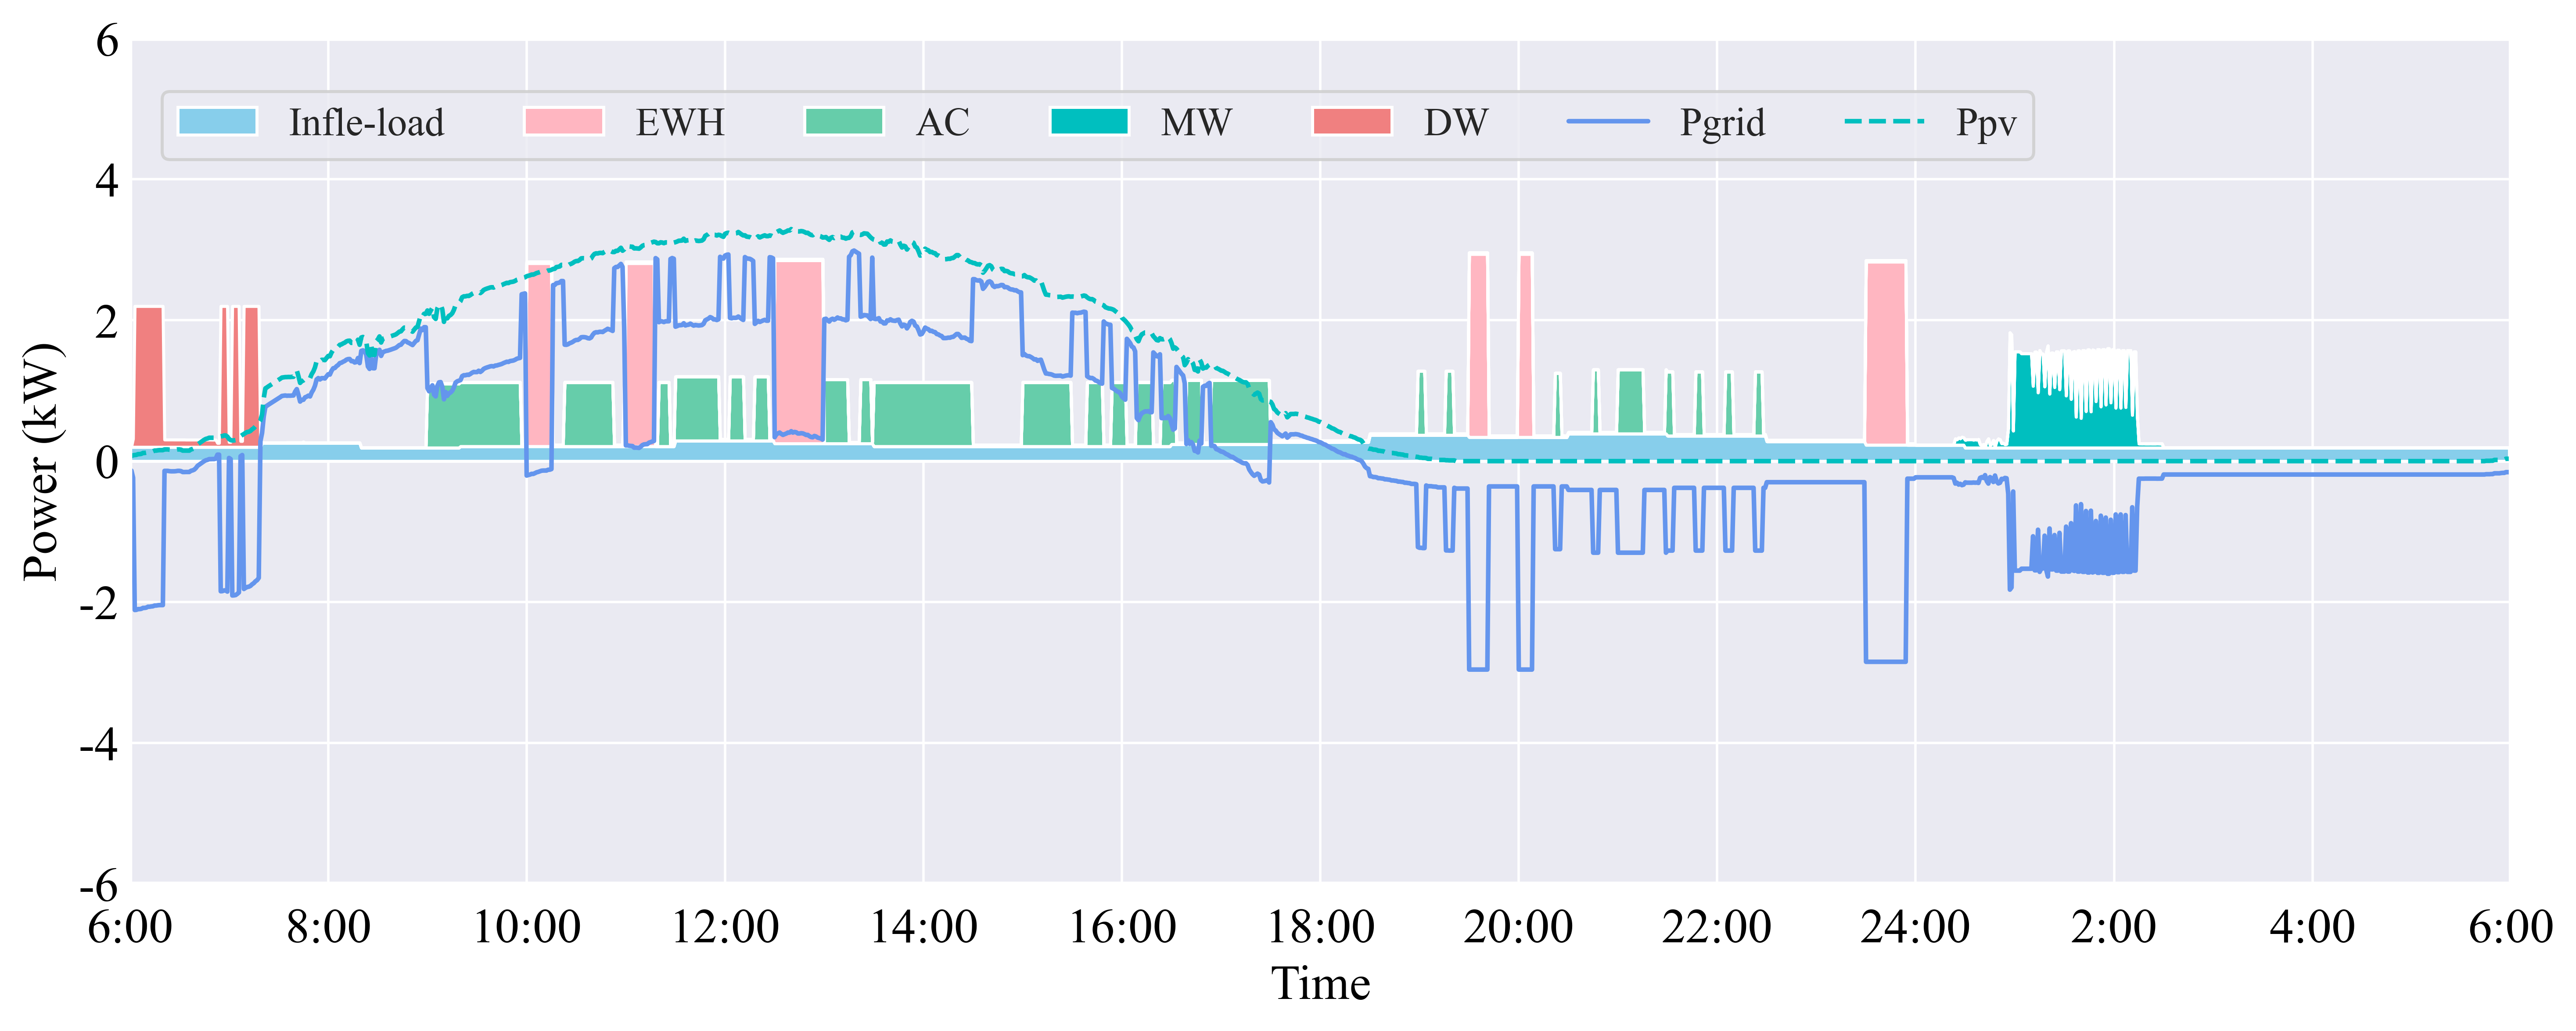

In [25]:
# Set up plot style
sns.set_style("darkgrid")
# Visualization
size_label = 16
size_tick = 16
size_legend = 13
fig = plt.figure(figsize=(14, 5), dpi=500) 
# plt.style.use('sns')
plt.stackplot(xx, P_infle/1000, P_in_ewh/1000, P_in_AC1/1000, P_in_wm/1000, P_in_dw/1000,
                      colors=('skyblue','lightpink','mediumaquamarine','c','lightcoral'), labels=('Infle-load', 'EWH', 'AC', 'MW','DW'))
plt.plot (xx, Pgrid/1000, '-', label = 'Pgrid',color = 'cornflowerblue',linewidth = 1.5)
plt.plot (xx, Pout_PV/1000, '--', label = 'Ppv',color = 'c',linewidth = 1.5)
plt.tick_params(axis='x', tickdir='in', labelsize=size_tick, pad=8)
plt.tick_params(axis='y', tickdir='in', labelsize=size_tick)
plt.xlim(0, 1440)
plt.ylim(-6, 6)  
plt.xlabel("Time", size=size_label, color='black')
plt.ylabel(r"Power (kW)", size=size_label, color='black')
x_major_locator = MultipleLocator(60*4) 
y_major_locator = MultipleLocator(2)  
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xticks(np.arange(0, len(P_in_ewh) + 1, 60 * 2),
                   ["6:00",'8:00','10:00', "12:00", '14:00',"16:00",'18:00', "20:00", '22:00',"24:00",'2:00', "4:00", "6:00"], size=size_tick, color='black')
plt.yticks(size=size_tick, color='black')
ax = plt.gca()  
ax.spines['top'].set_linewidth(1.5)  
ax.spines['bottom'].set_linewidth(1.5)  
ax.spines['left'].set_linewidth(1.5)  
ax.spines['right'].set_linewidth(1.5)  

fig.legend(loc='upper center', bbox_to_anchor=(0.44, 0.85), fontsize=size_legend, ncol=8)
mpl.rcParams['font.sans-serif'] = ['Times New Roman']  
mpl.rcParams['axes.unicode_minus'] = False  
plt.show()

# Experimential results 

Experiments were carried out to validate the proposed models and methods in a real environment using a real smart home energy system.Simulation results were compared with the experimental ones.

## Import test data

In [20]:
# AC
data_ac1 = pd.read_csv(test_path + '/AC temp huifeng.csv')
data_ac2 = pd.read_csv(test_path + '/AC indoor temp.csv')
data_ac3 = pd.read_csv(test_path + '/AC outdoor temp.csv')
data_ac4 = pd.read_csv(test_path + '/AC power.csv')
mn1 = data_ac1['temperature'].values
mn2 = data_ac2['temperature'].values
mn3 = data_ac3['temperature'].values
mn4 = data_ac4['power'].values
Pac_test = mn4[9*60:1440]
Tin_ac_test = mn1[9*60:1440]
T_out_test = mn3[9*60:1440]

# EWH
data_ewh1 = pd.read_csv(test_path + '/EWH ambient temp.csv')
data_ewh2 = pd.read_csv(test_path + '/EWH hot water temp.csv')
data_ewh4 = pd.read_csv(test_path + '/EWH power.csv')
Tewh_out_test = data_ewh1['temperature'].values
Tw_test = data_ewh2['temperature'].values
Pewh_test = data_ewh4['power'].values

# Dishwasher
data_dw = pd.read_csv(test_path + '/DW power.csv')
Pdw_test = data_dw['power'].values

# Washing and dryer
data_wm = pd.read_csv(test_path + '/WD power.csv')
Pwm_test = data_wm['power'].values

## Visualization of air conditioner test data

7.626632666666681 6.0765 0.20325256694763383


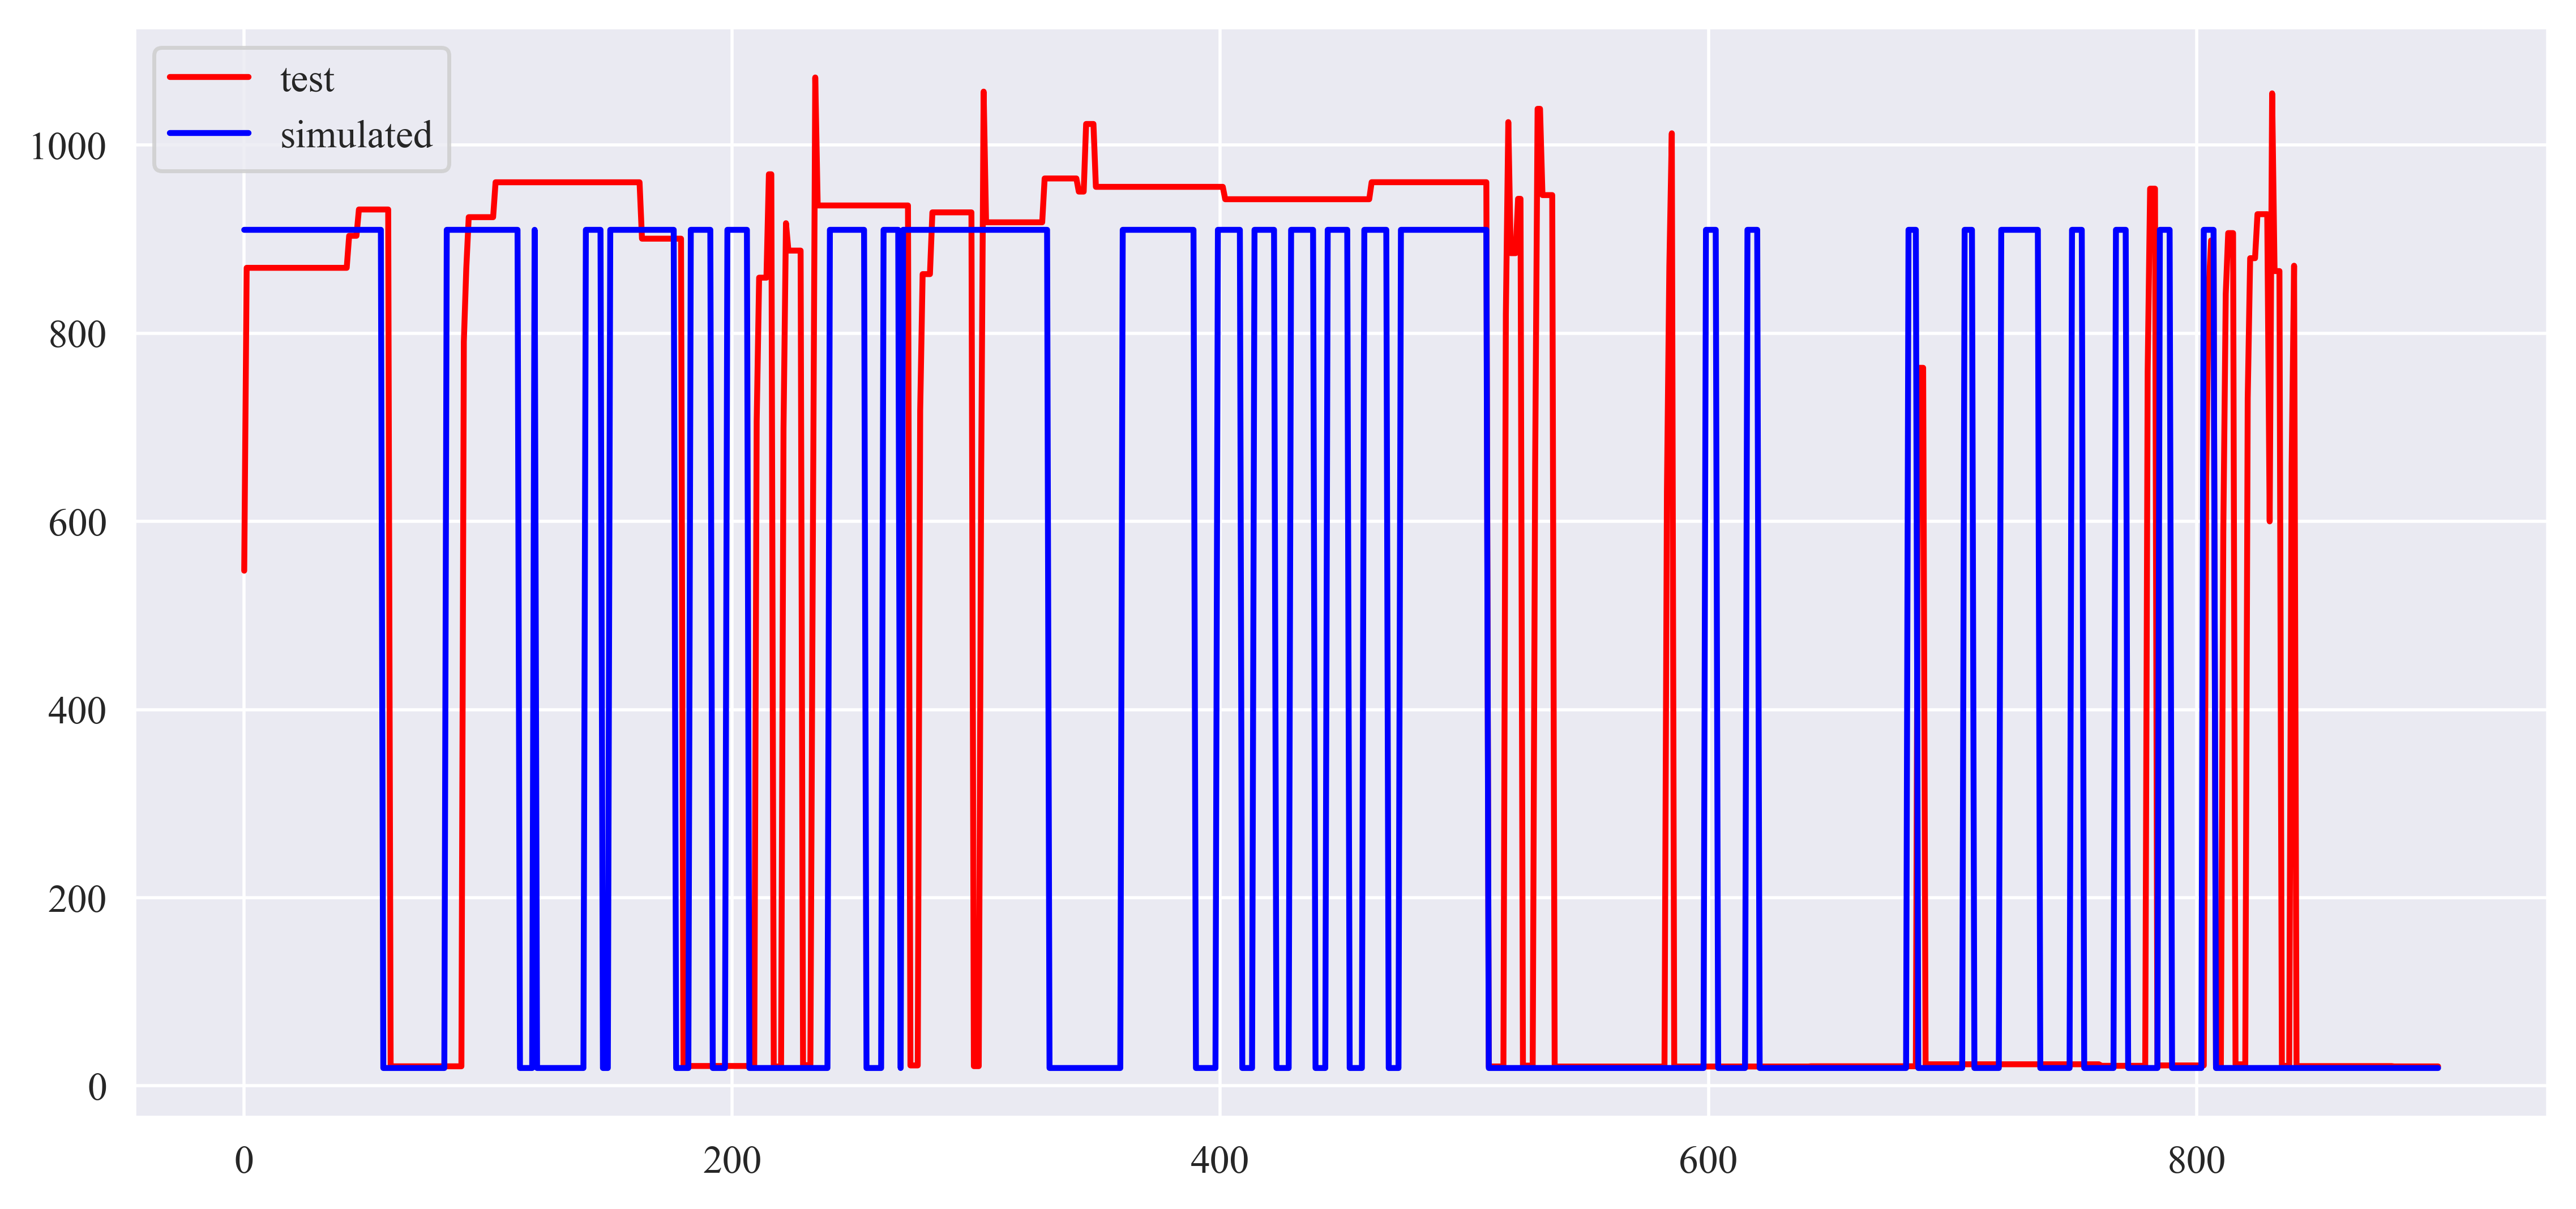

In [26]:
# Error calculation
Con_ac_test = sum(Pac_test)*60/1000/3600
Con_ac_sim = sum(P_ac1_m[3*60:18*60])*60/1000/3600
MAPE_ac = (Con_ac_test-Con_ac_sim)/Con_ac_test
print (Con_ac_test,Con_ac_sim,MAPE_ac)

fig = plt.figure(figsize=(11, 5), dpi=500)  
plt.plot(range(len(Pac_test)),Pac_test,'red', linewidth=1.5,label="test")
plt.plot(range(len(Pac_test)),P_ac1_m[3*60:18*60],'blue', linewidth=1.5,label="simulated")
plt.legend()
plt.show()

## Visualization of electric water heater test data

3.5448833333333334 4.766666666666667 -0.34466108428580156


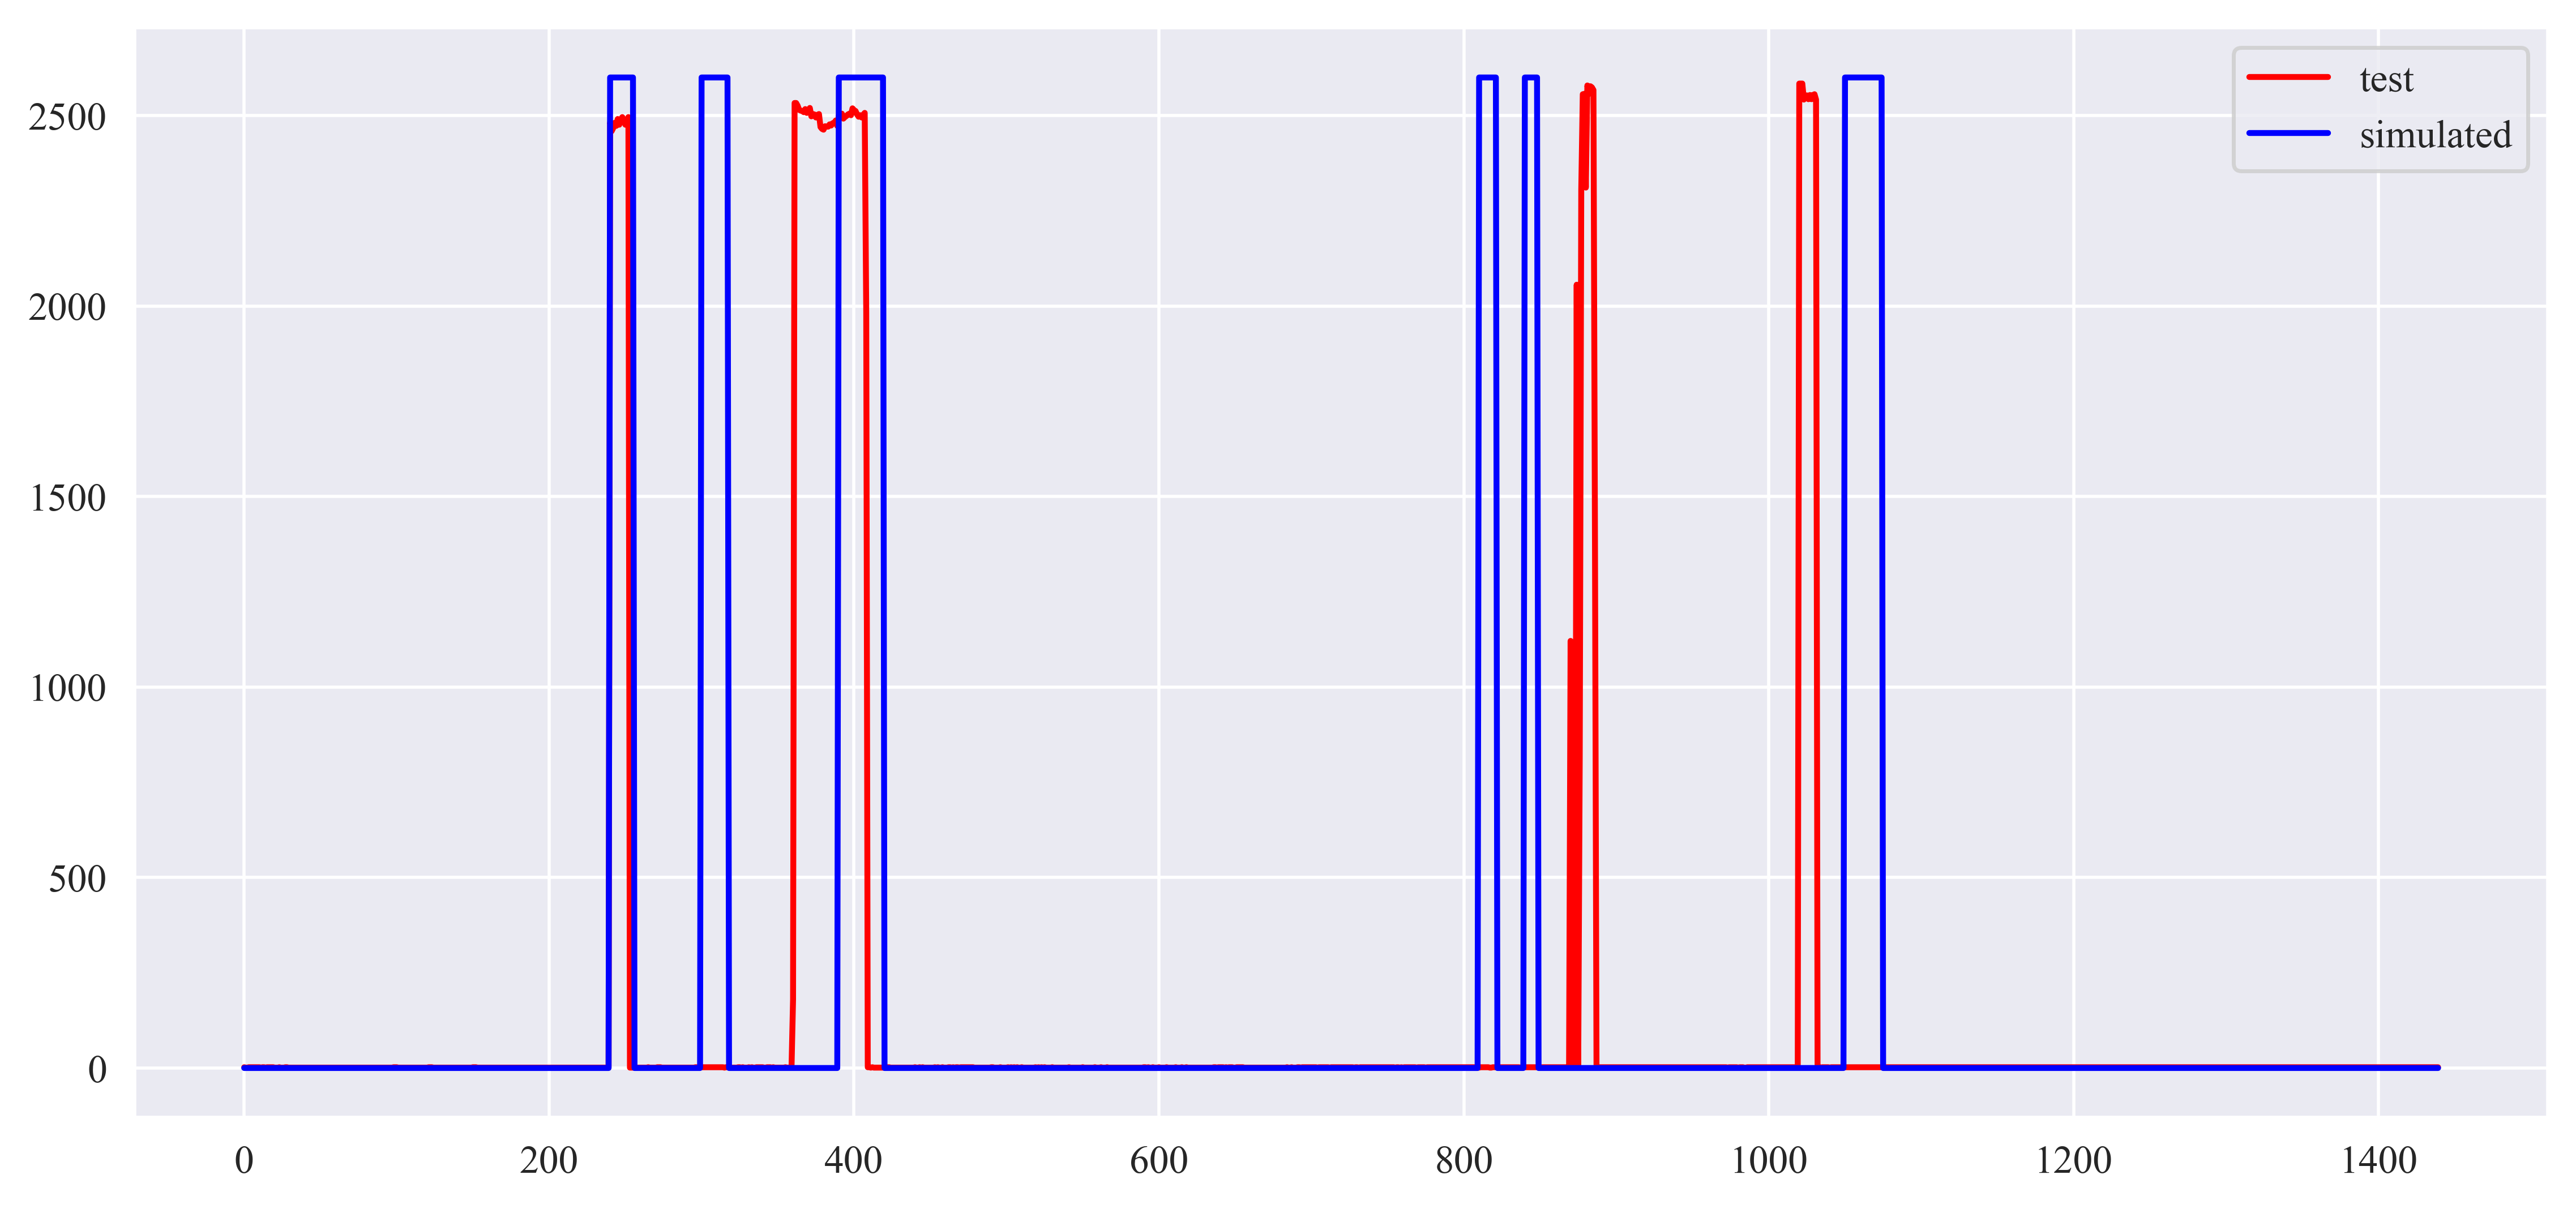

In [27]:
# Error calculation
Con_ewh_test = sum(Pewh_test)*60/1000/3600
Con_ewh_sim = sum(P_ewh)*60/1000/3600
MAPE_ewh = (Con_ewh_test-Con_ewh_sim)/Con_ewh_test
print (Con_ewh_test,Con_ewh_sim,MAPE_ewh)

fig = plt.figure(figsize=(11, 5), dpi=500) 
plt.plot(range(len(Pewh_test)),Pewh_test,'red', linewidth=1.5,label="test")
plt.plot(range(len(Pewh_test)),P_ewh,'blue', linewidth=1.5,label="simulated")
plt.legend()
plt.show()

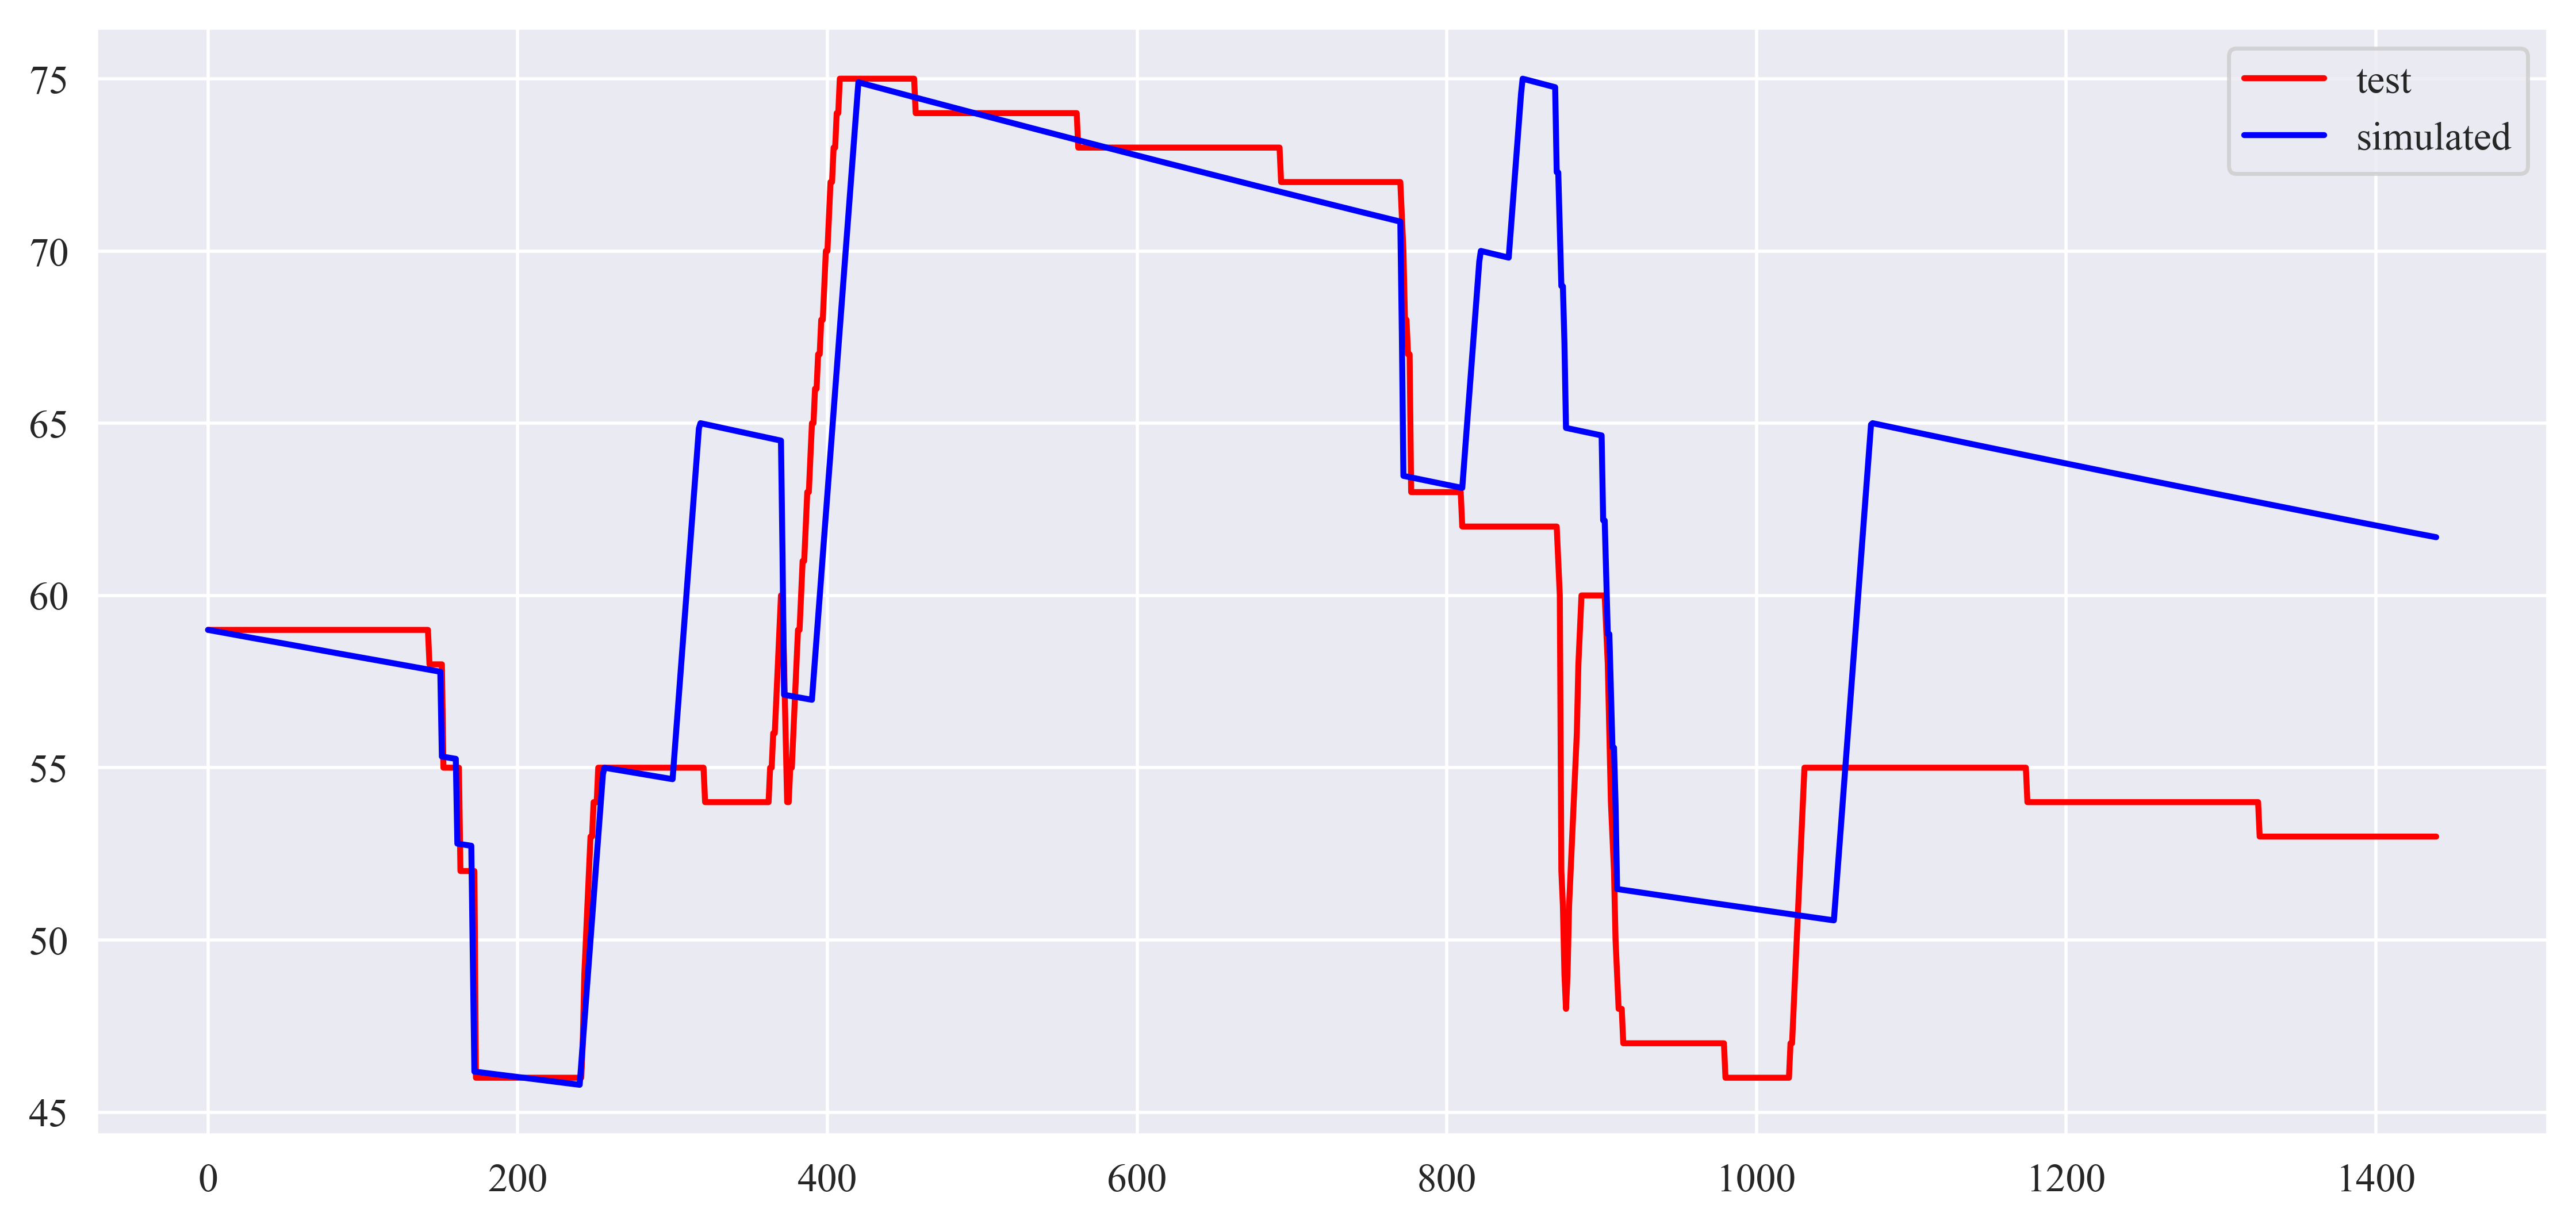

In [28]:
fig = plt.figure(figsize=(11, 5), dpi=500)  
plt.plot(range(len(Pewh_test)),Tw_test,'red', linewidth=1.5,label="test")
plt.plot(range(len(Pewh_test)),Tw_in[0:1440],'blue', linewidth=1.5,label="simulated")
plt.legend()
plt.show()

## Visualization of dishwasher test data

In [29]:
index_dw = int(decision_variable[m_ewh+m_ac+m_wm])
P_dw[index_dw:index_dw+106]

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_6365/3377188763.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  index_dw = int(decision_variable[m_ewh+m_ac+m_wm])


array([1.5060e+01, 6.9500e+00, 1.1752e+02, 2.0000e+03, 2.0000e+03,
       2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e+03,
       2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e+03,
       2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e+03,
       2.0000e+03, 1.0486e+02, 1.0486e+02, 1.0486e+02, 1.0486e+02,
       1.0486e+02, 1.0486e+02, 1.0441e+02, 1.0441e+02, 1.0441e+02,
       1.0441e+02, 1.0441e+02, 1.0441e+02, 1.0441e+02, 1.0350e+02,
       1.0350e+02, 1.0350e+02, 1.0350e+02, 1.0350e+02, 1.0350e+02,
       1.0350e+02, 1.0350e+02, 1.0350e+02, 1.0350e+02, 1.0350e+02,
       1.0350e+02, 1.0350e+02, 1.0350e+02, 1.0350e+02, 1.0350e+02,
       1.0260e+02, 1.0260e+02, 1.0260e+02, 5.6500e+01, 5.6500e+01,
       2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e+03,
       7.0060e+01, 7.0060e+01, 2.0000e+03, 2.0000e+03, 2.0000e+03,
       2.0000e+03, 2.0000e+03, 8.4070e+01, 8.4070e+01, 2.0000e+03,
       2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e+03, 2.0000e

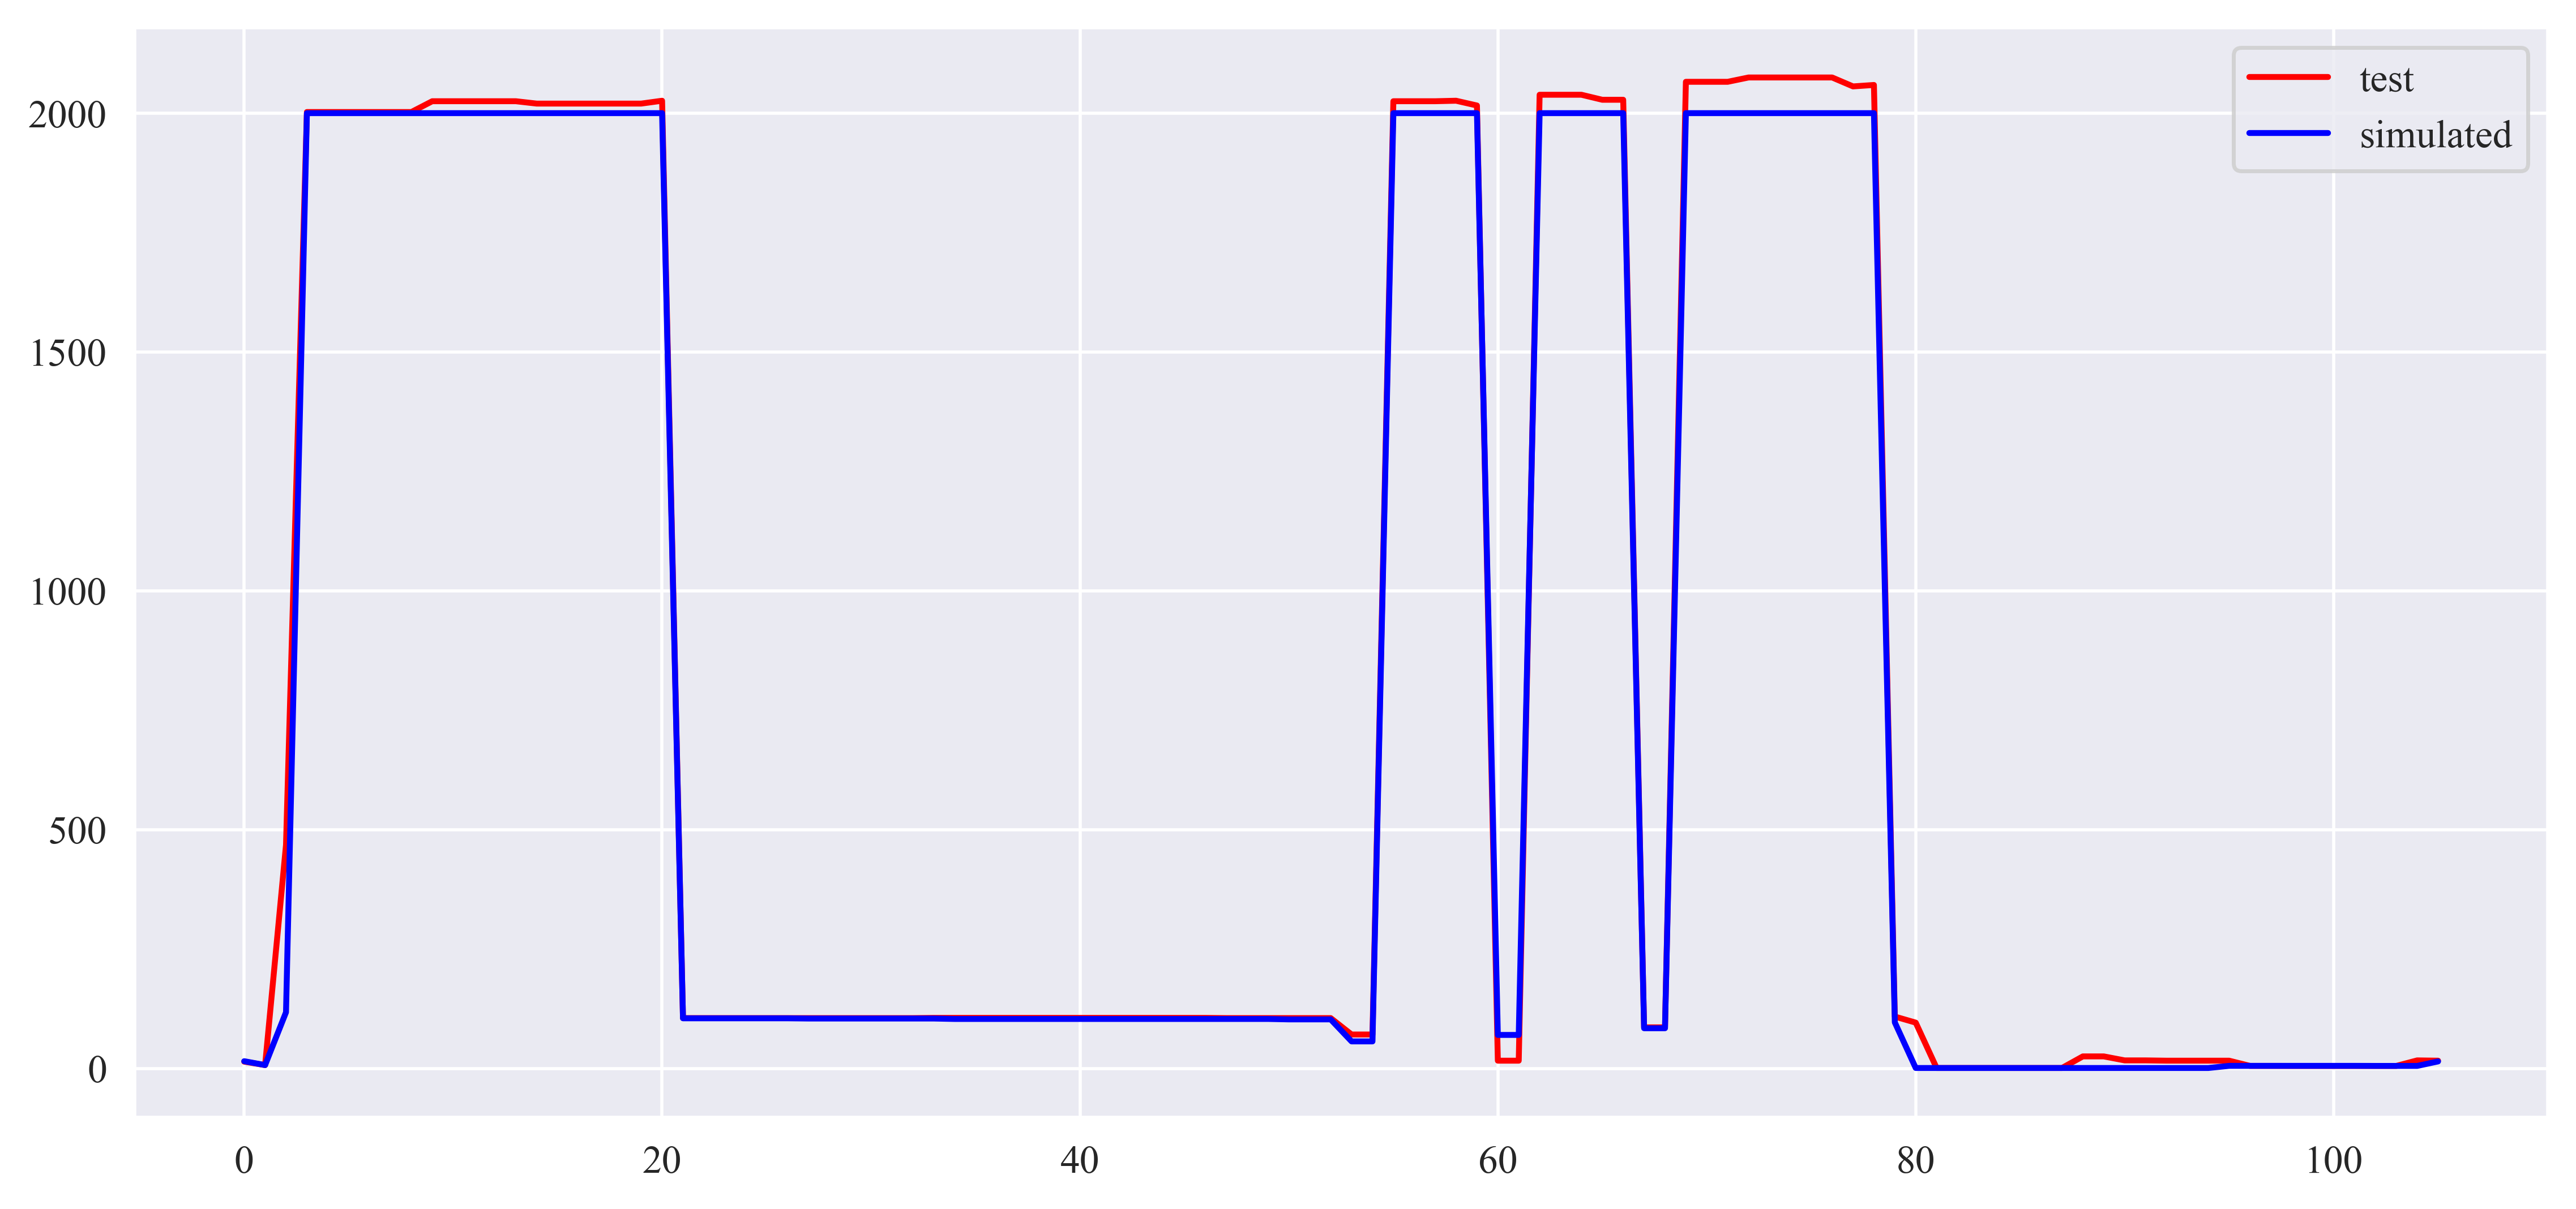

In [30]:
fig = plt.figure(figsize=(11, 5), dpi=500) 
plt.plot(range(len(Pdw_test)),Pdw_test,'red', linewidth=1.5,label="test")
plt.plot(range(len(Pdw_test)),P_dw[index_dw:index_dw+106],'blue', linewidth=1.5,label="simulated")
plt.legend()
plt.show()

## Visualization of washing and dryer test data

In [32]:
index_wm = int(decision_variable[m_ewh+m_ac])
P_wm[index_wm:index_wm+127]

/var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/ipykernel_6365/2369001059.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  index_wm = int(decision_variable[m_ewh+m_ac])


array([   9.42,   88.6 ,   76.62,  103.21,   92.14,  111.19,  104.1 ,
        111.63,  116.06,  116.06,  116.5 ,  116.5 ,  113.85,  116.06,
        114.29,  119.16,   47.4 ,   36.91,   48.73,    9.04,   93.03,
        128.47,   36.91,   53.16,  106.32,   14.76,   97.46,  126.69,
        117.39,   62.02,   66.44,   48.73,   53.16,  273.76, 1634.67,
       1603.66,  241.43, 1364.44, 1364.44, 1364.44, 1364.44, 1337.86,
       1337.86, 1337.86, 1337.86, 1337.86, 1337.86, 1337.86,  877.14,
       1360.01, 1360.01,  784.11, 1382.16, 1333.43, 1333.43,  868.28,
       1355.58, 1448.61,  766.39, 1346.72, 1346.72,  859.42, 1364.44,
       1364.44,  828.41, 1377.73, 1377.73, 1377.73,  739.81, 1377.73,
       1377.73,  691.08, 1360.01, 1368.87,  438.57, 1377.73, 1377.73,
        420.85, 1382.16, 1382.16,  518.31, 1391.02, 1391.02,  513.88,
       1391.02, 1382.16,  660.07, 1395.45, 1395.45,  584.76, 1395.45,
       1395.45,  611.34, 1408.74, 1408.74,  642.34, 1395.45, 1395.45,
        567.03, 1386

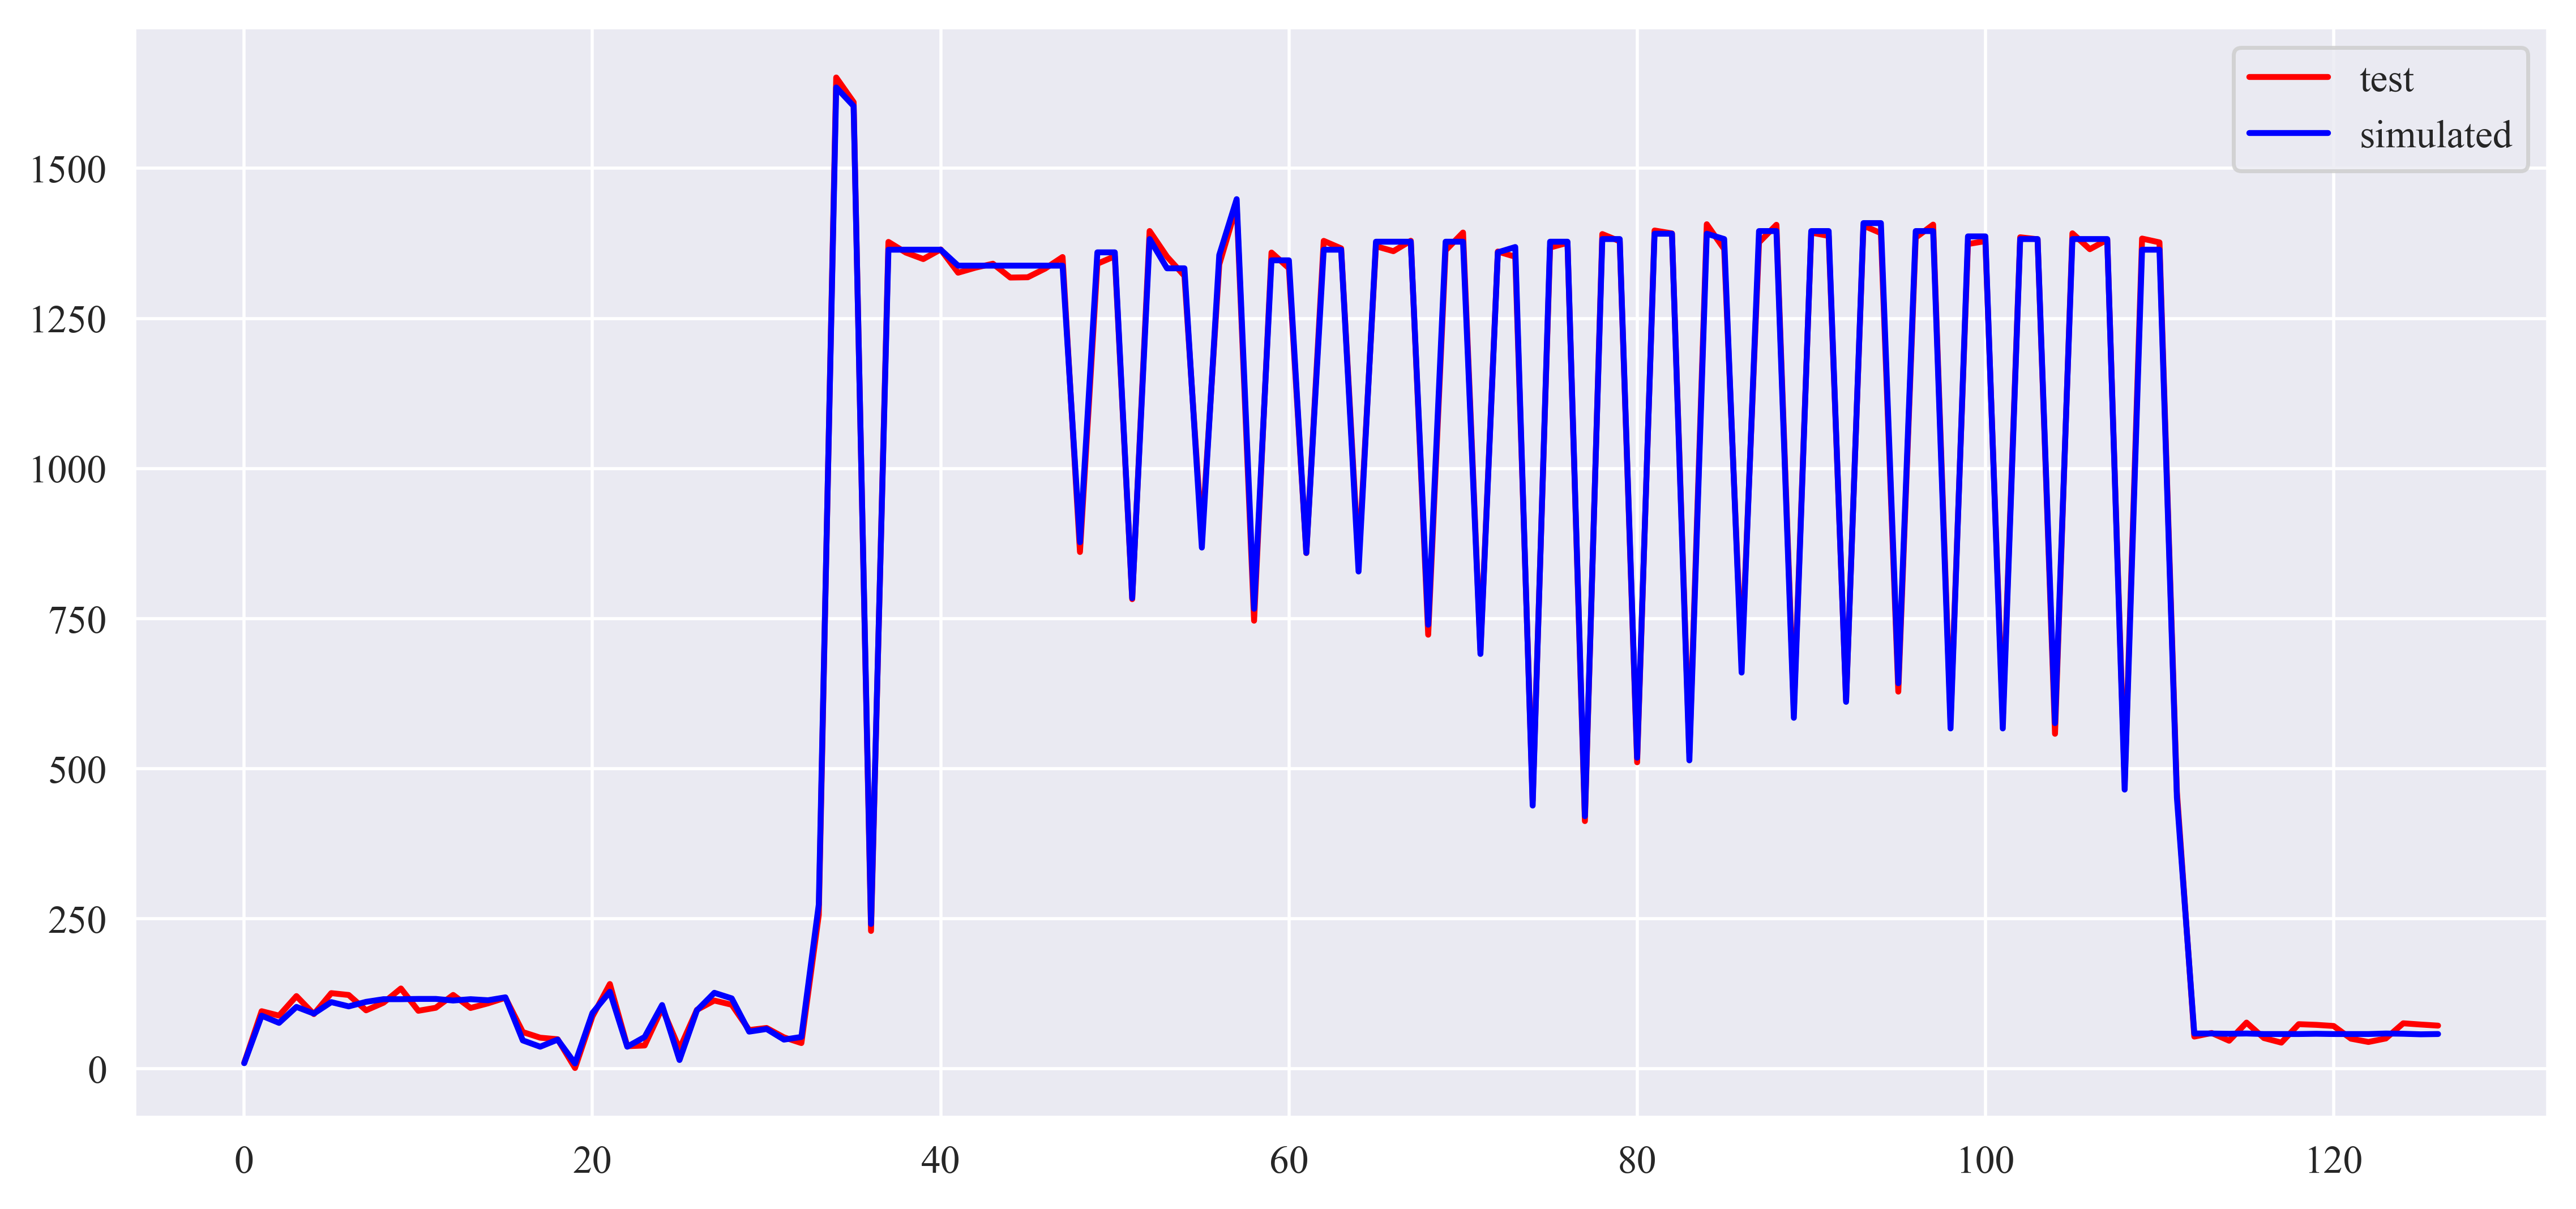

In [34]:
fig = plt.figure(figsize=(11, 5), dpi=500)  
plt.plot(range(len(Pwm_test)),Pwm_test,'red', linewidth=1.5,label="test")
plt.plot(range(len(Pwm_test)),P_wm[index_wm:index_wm+127],'blue', linewidth=1.5,label="simulated")
plt.legend()
plt.show()

## Comparation betweent the tested system net power and the simulated one

In [35]:
#The tested net power, time resolution is 1 min
AC = np.zeros(1440)
AC[3*60:18*60]=Pac_test
WM = np.zeros(1440)
WM[index_wm:index_wm+127] = Pwm_test
DW = np.zeros(1440)
DW[index_dw:index_dw+106] = Pdw_test
Pload_test = Pewh_test+AC+WM+DW+P_infle_load
Pnet_test = Pout_PV - Pload_test

# Aeverage net power, every half an hour
a1 = 30
Etest = np.zeros(int(1440/a1))
Esim = np.zeros(int(1440/a1))
for i in range (int(1440/a1)):
    Etest[i] = sum(Pnet_test[i*a1:(i+1)*a1])/a1
    Esim[i] = sum(Pgrid[i*a1:(i+1)*a1])/a1
 

MAE=103.6593W
MAPE=-0.0663


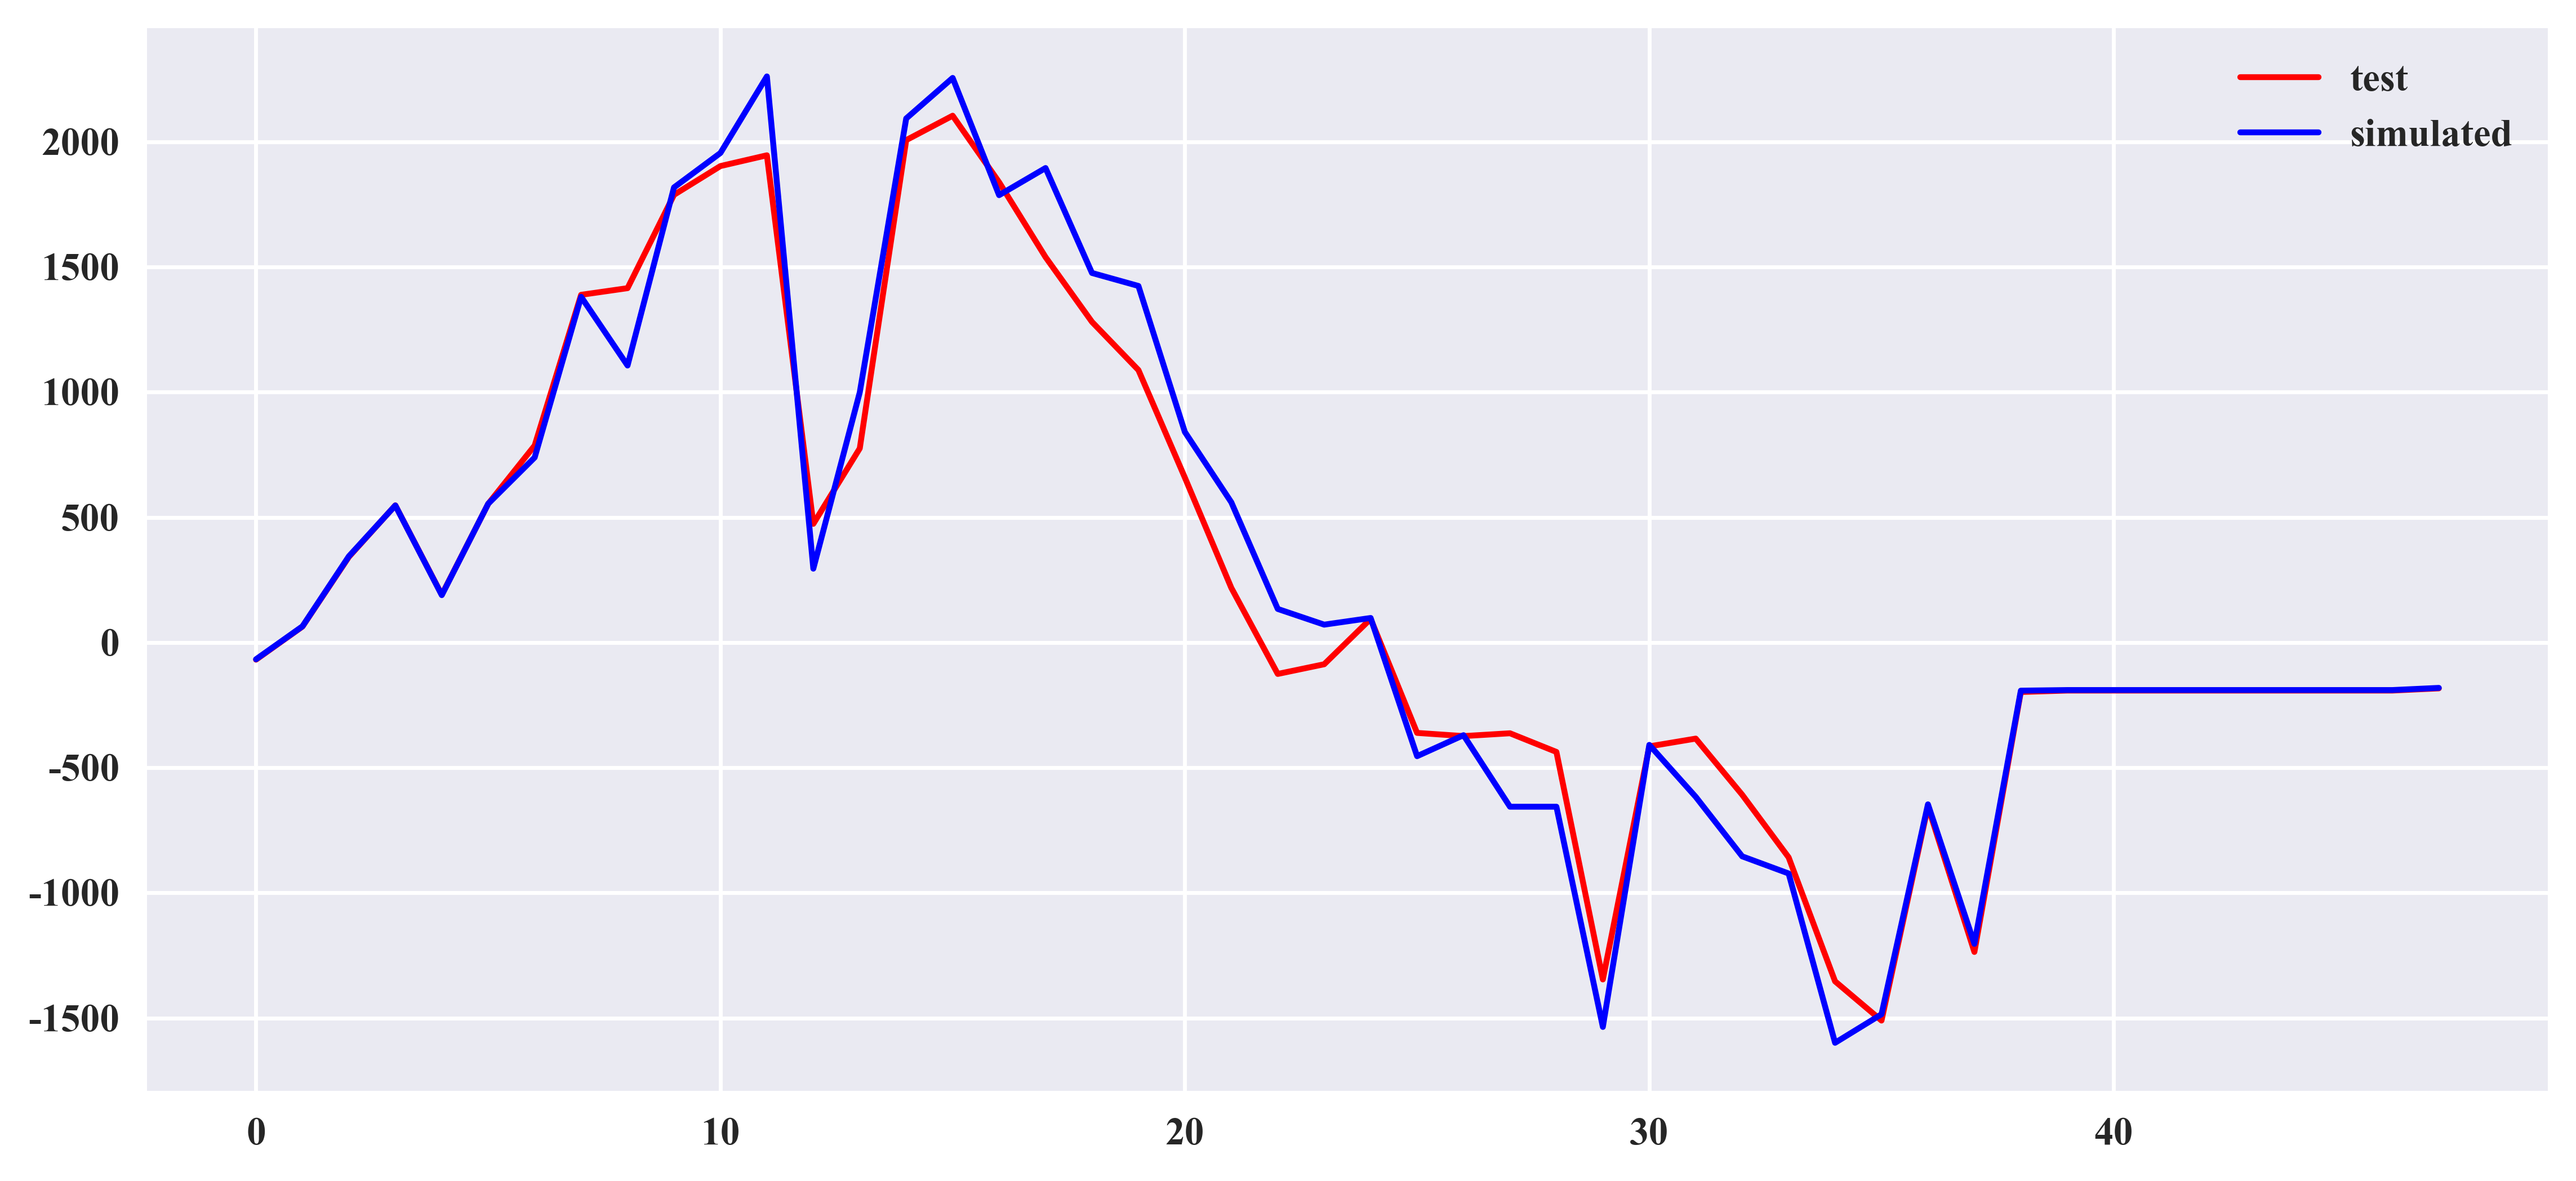

In [20]:
# Error calculation
def Wucha (Y_pred,Y_test):
    AUM = 0
    APE = 0
    for i in range (0, len(Y_pred),1):
        AUM = AUM+abs(Y_pred [i] - Y_test [i])
        APE = APE+abs(Y_pred [i] - Y_test [i])/Y_test [i]

    MAE = AUM/len(Y_pred) 
    MAPE = APE/len(Y_pred) 
    
    return MAE, MAPE

MAE, MAPE = Wucha(Esim,Etest) 
print("MAE=%.4fW" % MAE) 
print("MAPE=%.4f" % MAPE)

fig = plt.figure(figsize=(11, 5), dpi=500) 
plt.plot(range(len(Etest)),Etest,'red', linewidth=1.5,label="test")
plt.plot(range(len(Etest)),Esim,'blue', linewidth=1.5,label="simulated")
plt.legend()
plt.show()